In [77]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [78]:
src_dir_path = '/home/hwkang/dev-TSB-AD/TSB-AD/eval/encodings'
file_names = os.listdir(src_dir_path)
file_paths = [os.path.join(src_dir_path, file_name) for file_name in file_names]

In [79]:
ts_type = 'SMD'

file_paths = sorted(file_paths)

if ts_type == 'MSL':
    file_paths = file_paths[:16]
elif ts_type == 'SMD':
    file_paths = file_paths[16:32]

#print(file_paths)
#print(len(file_paths))

In [80]:
# get list from file_paths which contains '_enc' in the name
file_paths_x_enc = [file_path for file_path in file_paths if '_enc' in file_path]
file_paths_x_raw = [file_path for file_path in file_paths if '_raw' in file_path]

In [81]:
file_paths_x_enc = sorted(file_paths_x_enc)
file_paths_x_raw = sorted(file_paths_x_raw)

In [82]:
method_results = {}
for file_path_x_enc, file_path_x_raw in zip(file_paths_x_enc, file_paths_x_raw):
    # Extract the file name without the extension
    file_name = os.path.splitext(os.path.basename(file_path_x_enc))[0]
    method_name = file_name.split('_')[11:-1]
    method_name = '_'.join(method_name)
    
    # load data from file
    x_enc = np.load(file_path_x_enc)
    x_raw = np.load(file_path_x_raw)

    method_results[method_name] = [x_enc, x_raw]
#print(method_results.keys())

In [83]:
axes_pos = {
    'baseline': (0, 0),
    'scof_no_ternary': (0, 1),
    'scof_ternary': (1, 1),
    'nlt_no_ternary': (0, 2),
    'nlt_ternary_det': (1, 2),
    'scalar_no_ternary': (0, 3),
    'scalar_ternary_det': (1, 3),
    'rate_ternary': (1, 4),
}

In [84]:
def plot_info_loss_evolution(axes_pos, method_results, sim_type='MSE'):
    # Subplots 2x5
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))

    y_min = np.inf
    y_max = -np.inf

    # Dataframe columns with keys of axes_pos
    df = pd.DataFrame(columns=axes_pos.keys())

    for name, pos in axes_pos.items():
    
        # Select the axis with pos
        ax = axes[pos]
        result = method_results[name]
        x_enc, x_raw = result

        num_epochs = x_enc.shape[0]

        info_loss_evolution = []
        for epoch in range(num_epochs):
            # Flatten the arrays
            x_enc_flat = x_enc[epoch].flatten()
            x_raw_flat = x_raw[epoch].flatten()

            # Normalize the data
            x_enc_flat = (x_enc_flat - np.min(x_enc_flat)) / (np.max(x_enc_flat) - np.min(x_enc_flat))
            x_raw_flat = (x_raw_flat - np.min(x_raw_flat)) / (np.max(x_raw_flat) - np.min(x_raw_flat))

            if sim_type == 'MSE':
                # Calculate Similarity using MSE
                sim = np.mean((x_enc_flat - x_raw_flat) ** 2)
            elif sim_type == 'Cosine':
                # Calculate Similarity using Cosine Similarity
                dot_product = np.dot(x_enc_flat, x_raw_flat)
                norm_enc = np.linalg.norm(x_enc_flat)
                norm_raw = np.linalg.norm(x_raw_flat)
                sim = 1 - (dot_product / (norm_enc * norm_raw))
            elif sim_type == 'MAE':
                # Calculate Similarity using MAE
                sim = np.mean(np.abs(x_enc_flat - x_raw_flat))
            info_loss_evolution.append(sim)

            if sim < y_min:
                y_min = sim
            if sim > y_max:
                y_max = sim

            # put info_loss_evolution list into the dataframe matching the name
            # info_loss_evolution is a list of length num epochs which include the similarity
        df[name] = info_loss_evolution

        # Plot the information loss evolution
        ax.plot(range(num_epochs), info_loss_evolution, label=name)
        ax.set_title(name)
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Information Loss')

    # Turn off the unused subplots
    for i in range(2):
        for j in range(5):
            if (i, j) not in axes_pos.values():
                axes[i, j].axis('off')
            else:
                axes[i, j].set_ylim(y_min-0.01, y_max+0.01)

    # Super title as sim_type
    fig.suptitle(f'{sim_type}', fontsize=16)

    plt.tight_layout()
    plt.show()

    return df

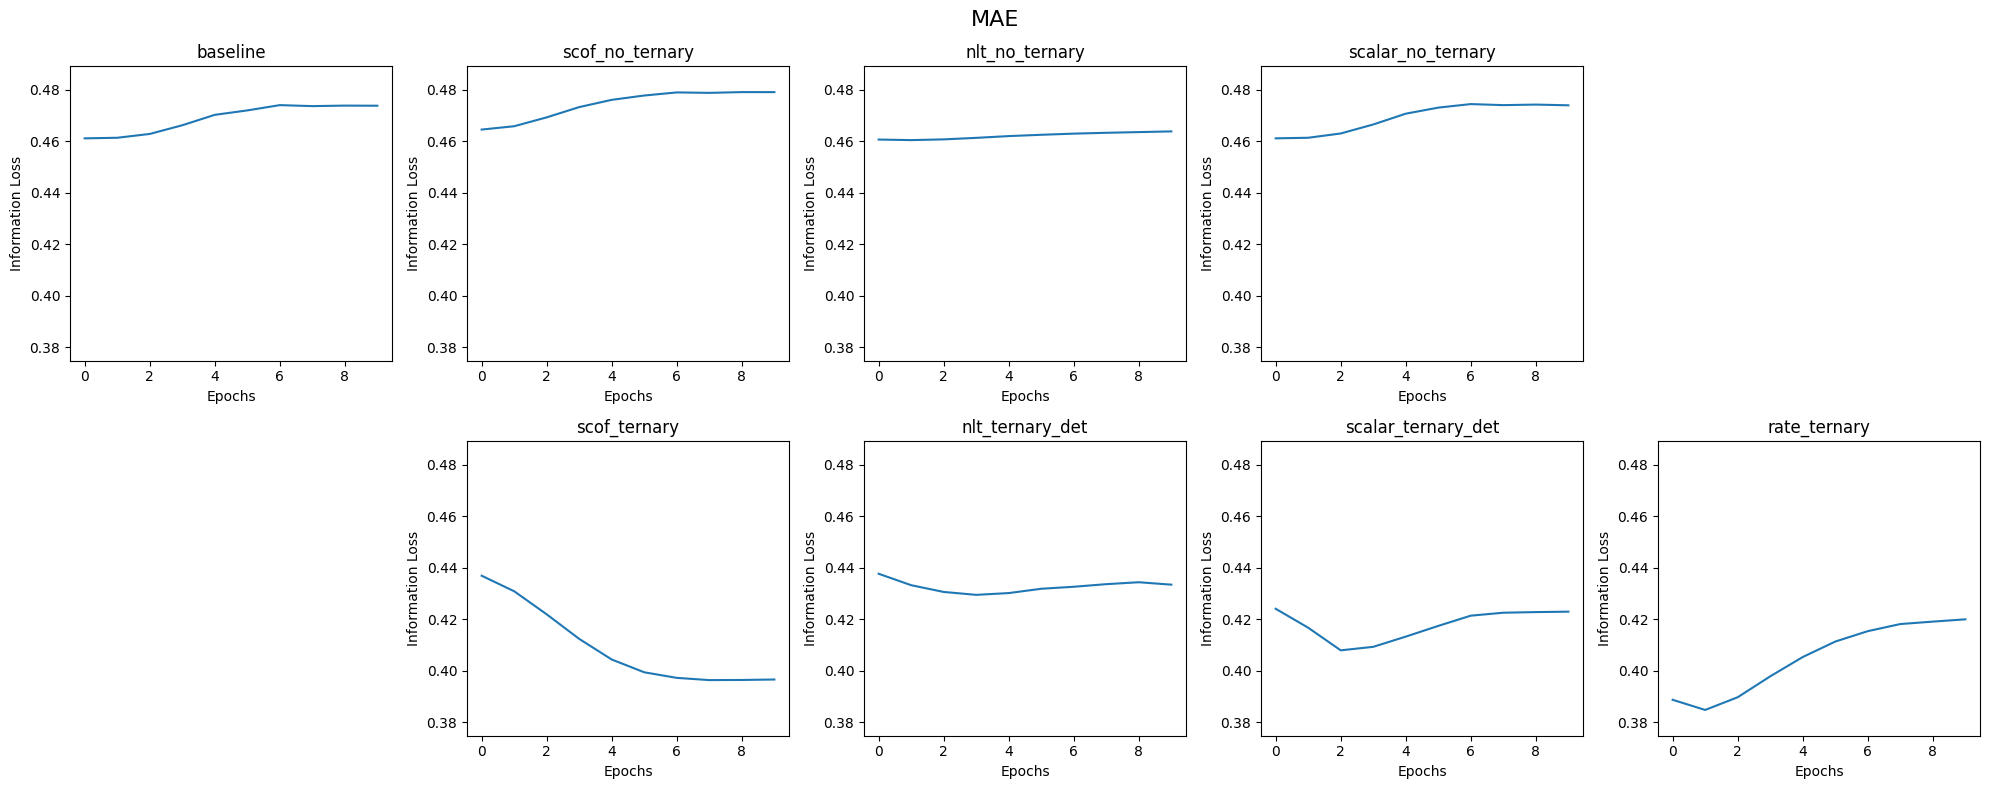

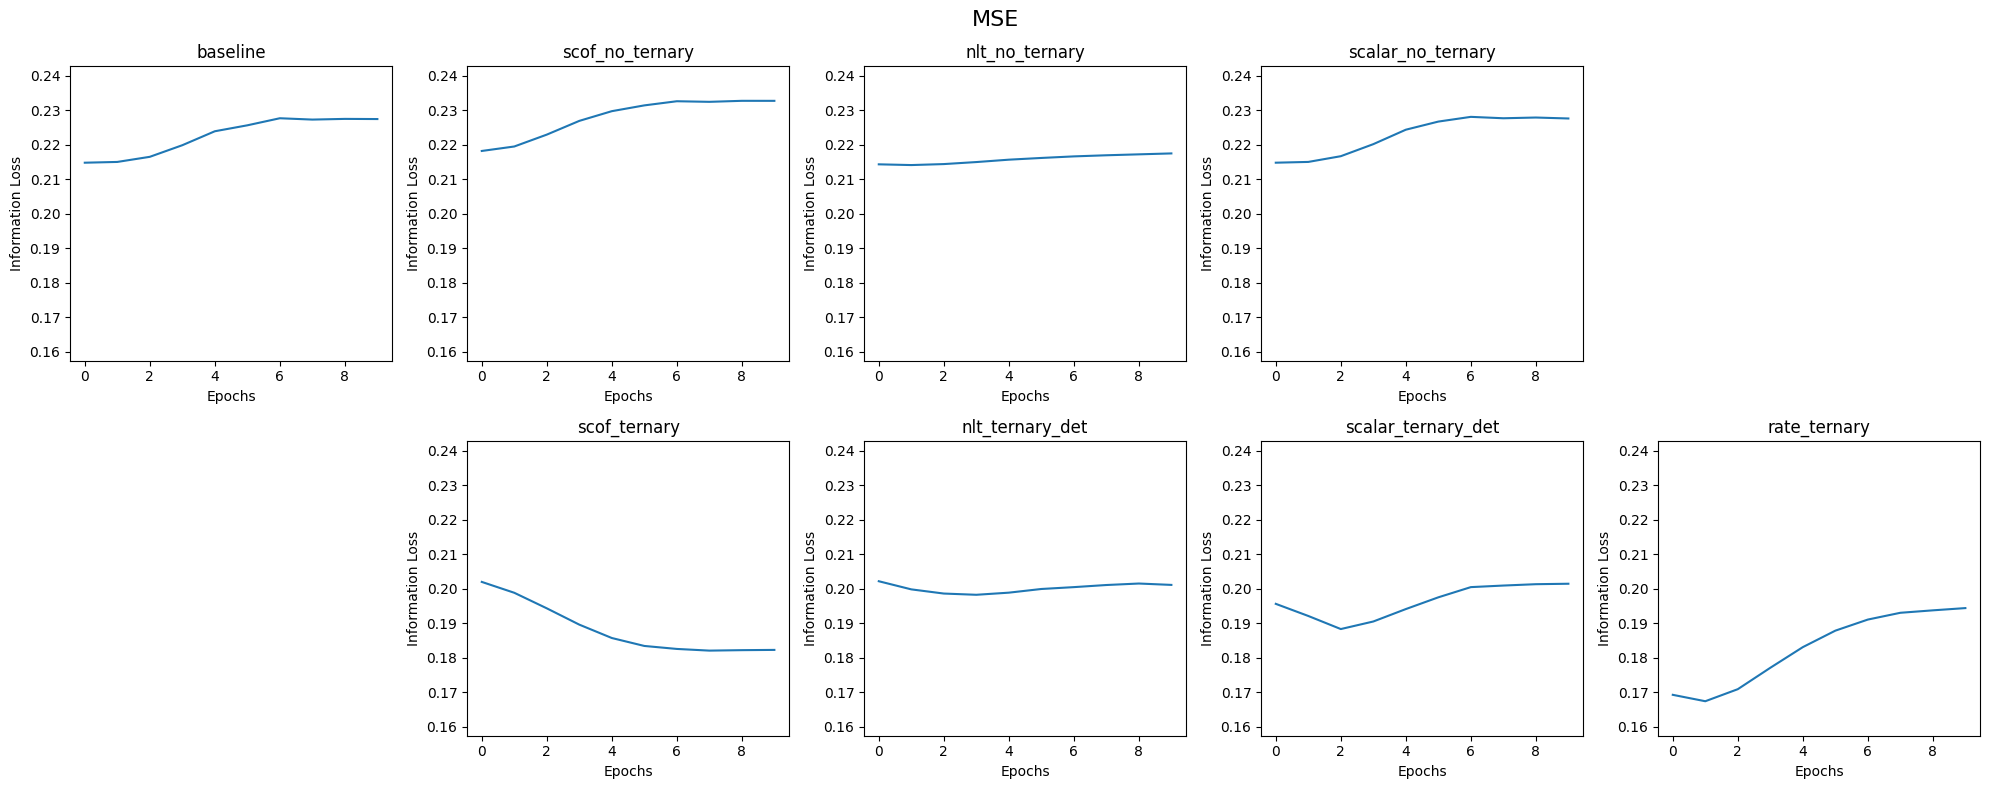

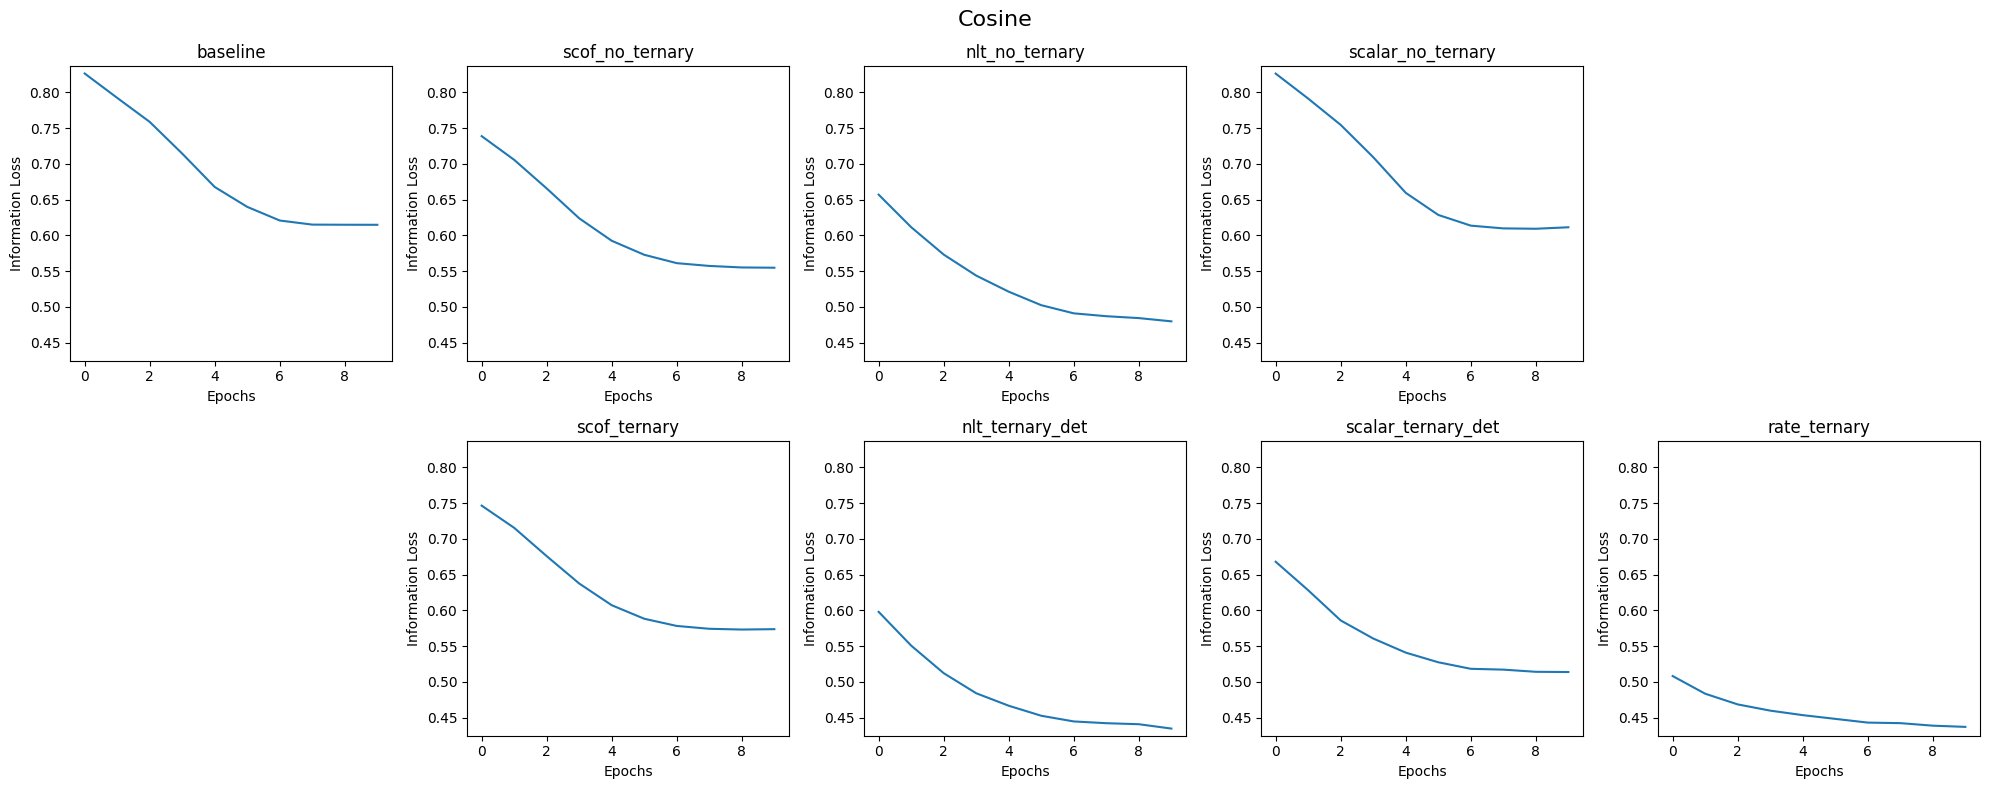

In [85]:
df_MAE = plot_info_loss_evolution(axes_pos, method_results, sim_type='MAE')
df_MSE = plot_info_loss_evolution(axes_pos, method_results, sim_type='MSE')
df_Cosine = plot_info_loss_evolution(axes_pos, method_results, sim_type='Cosine')

In [86]:
df_MAE.describe()

,baseline,scof_no_ternary,scof_ternary,nlt_no_ternary,nlt_ternary_det,scalar_no_ternary,scalar_ternary_det,rate_ternary
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.468900,0.474258,0.409284,0.462128,0.432724,0.469238,0.417866,0.405071
std,0.005472,0.005732,0.015473,0.001278,0.002381,0.005652,0.005938,0.013741
min,0.461128,0.464534,0.396417,0.460445,0.429497,0.461131,0.407971,0.384836
25%,0.463677,0.470269,0.396809,0.460877,0.430935,0.463888,0.414154,0.391797
50%,0.471107,0.476910,0.401927,0.462256,0.432943,0.471875,0.419439,0.408373
75%,0.473747,0.478908,0.419556,0.463203,0.433600,0.474000,0.422749,0.417483
max,0.474020,0.479073,0.436926,0.463820,0.437684,0.474422,0.424102,0.420001


In [87]:
df_MSE.describe()

,baseline,scof_no_ternary,scof_ternary,nlt_no_ternary,nlt_ternary_det,scalar_no_ternary,scalar_ternary_det,rate_ternary
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.222536,0.227894,0.188257,0.215764,0.200147,0.222874,0.196198,0.182737
std,0.005472,0.005732,0.007545,0.001278,0.001320,0.005652,0.004856,0.010795
min,0.214764,0.218170,0.182026,0.214081,0.198214,0.214767,0.188277,0.167348
25%,0.217312,0.223905,0.182302,0.214513,0.199068,0.217524,0.192571,0.172395
50%,0.224743,0.230546,0.184529,0.215892,0.200164,0.225510,0.196532,0.185423
75%,0.227383,0.232544,0.193102,0.216839,0.201071,0.227636,0.200778,0.192503
max,0.227656,0.232708,0.201949,0.217456,0.202143,0.228058,0.201416,0.194356


In [88]:
df_Cosine.describe()

,baseline,scof_no_ternary,scof_ternary,nlt_no_ternary,nlt_ternary_det,scalar_no_ternary,scalar_ternary_det,rate_ternary
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.686601,0.612869,0.627140,0.535201,0.482766,0.681474,0.557554,0.458394
std,0.080966,0.068200,0.064450,0.060892,0.054861,0.083201,0.053929,0.022775
min,0.614921,0.554888,0.573316,0.479880,0.434811,0.609389,0.513885,0.437177
25%,0.616604,0.558358,0.575365,0.488073,0.442934,0.612022,0.517538,0.442595
50%,0.653869,0.582765,0.597856,0.511911,0.459744,0.644162,0.534284,0.450991
75%,0.747744,0.655288,0.666392,0.565915,0.505269,0.743357,0.579710,0.466438
max,0.826546,0.738922,0.746624,0.657048,0.598049,0.826386,0.668169,0.508251
